# **Data Visualization Notebook**

## Objectives

* Answer business requirement 1:
    * The client is interesto in having a study to visually differentiate a healthy human brain MRI from the one with tumor

## Inputs

* The inputs consist of the images that are divided according to the following directory schema:

    ```
    input/
    ├── test
    │   ├── mri-non-tumor
    │   └── mri-tumor
    ├── train
    │   ├── mri-non-tumor
    │   └── mri-tumor
    └── validation
        ├── mri-non-tumor
        └── mri-tumor
    ```
## Outputs

* Image shape embeddings pickle file.
* Mean and variability of images per label plot.
* Plot to distinguish the contrast between healthy brain MRI and the one with a tumor.
* Generate code that answers business requirement 1 and can be used to build an image montage on the Streamlit dashboard.


## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 


---

# Set Data Directory

---

## Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

# Set working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
current_dir = os.getcwd()
current_dir

'/home/tom/codeinstitute/brain-tumor-detect/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
working_dir = os.getcwd()
working_dir

'/home/tom/codeinstitute/brain-tumor-detect'

# Set Input Directories

Set train, validation and test paths.

In [5]:
input_dir = 'input'
train_path = os.path.join(input_dir, 'train')
test_path = os.path.join(input_dir, 'test')
validation_path = os.path.join(input_dir, 'validation')



In [6]:
version = 'v2'
file_path = os.path.join('outputs', version)

if 'outputs' in os.listdir(working_dir) and version in os.listdir(os.path.join(working_dir, 'outputs')):
    print('This version of the output dataset already exists.')
    pass
else:
    os.makedirs(name=file_path)

This version of the output dataset already exists.


# Set label names

In [7]:
# Set the labels
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['mri-tumor', 'mri-non-tumor']


## Image Shape

Though the images are of the same shape, we should nevertheless compute the average image size of the train set.

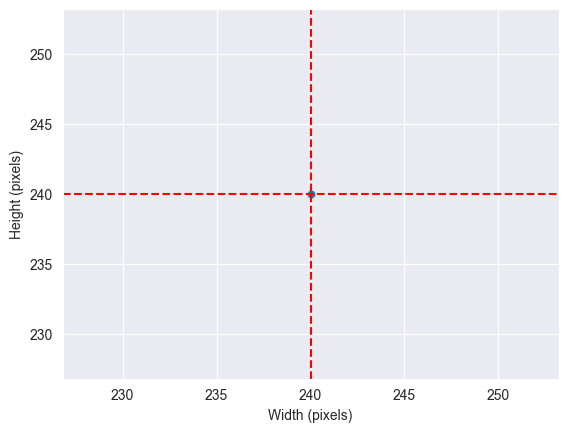

Width average: 240 
Height average: 240


In [8]:
# analyse image dimensions
image_height, image_width = [], []
for label in labels:
    for image_file in os.listdir(os.path.join(train_path, label)):
        image = imread(os.path.join(train_path, label, image_file))
        image_height.append(image.shape[0])
        image_width.append(image.shape[1])

# plot image dimension graph
sns.set_style("darkgrid")
fig, axes = plt.subplots()
sns.scatterplot(x=image_width, y=image_height, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
image_height_mean = int(np.array(image_height).mean())
image_width_mean = int(np.array(image_width).mean())
axes.axvline(x=image_height_mean, color='r', linestyle='--')
axes.axhline(y=image_width_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {image_width_mean} \nHeight average: {image_height_mean}")



As remarked before, all images have the same dimension, what is visible in this diagram.

In [9]:
# image_shape = (image_height_mean, image_width_mean, 3)
# instead of taking the identified mean dimensions of the images,
# we will decrease the dimensions in order to increase speed of model training
image_shape = (int(image_height_mean/2.5), int(image_width_mean/2.5), 3)
image_shape

(96, 96, 3)

Save the image shape embeddings (will serve for the uploading a MRI brain scan that is not from the dataset)

In [10]:
joblib.dump(value=image_shape,
            filename=os.path.join(file_path, 'image_shape.pkl'))

['outputs/v2/image_shape.pkl']

---

# Average and variablity of images per label

## Load images in an array

In [11]:
from tensorflow.keras.preprocessing import image


def load_image_as_array(data_dir, new_size=(50, 50), n_images_per_label=20):

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(data_dir)

    for label in labels:
        counter = 0
        for image_file in os.listdir(os.path.join(data_dir, label)):
            # n_images_per_label: we set a limit, since it may take too much time
            if counter < n_images_per_label:

                img = image.load_img(os.path.join(data_dir, label, image_file), target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1,
                                                      new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y


## Load image shapes and labels in an array

In [12]:
X, y = load_image_as_array(data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)

(60, 96, 96, 3) (60,)


## Plot and save mean and variability of images per label

In [13]:
def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False):

    for label_to_display in np.unique(y):
        sns.set_style("white")

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')

        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")

==== Label mri-non-tumor ====
Image Shape: (96, 96, 3)


==== Label mri-tumor ====
Image Shape: (96, 96, 3)


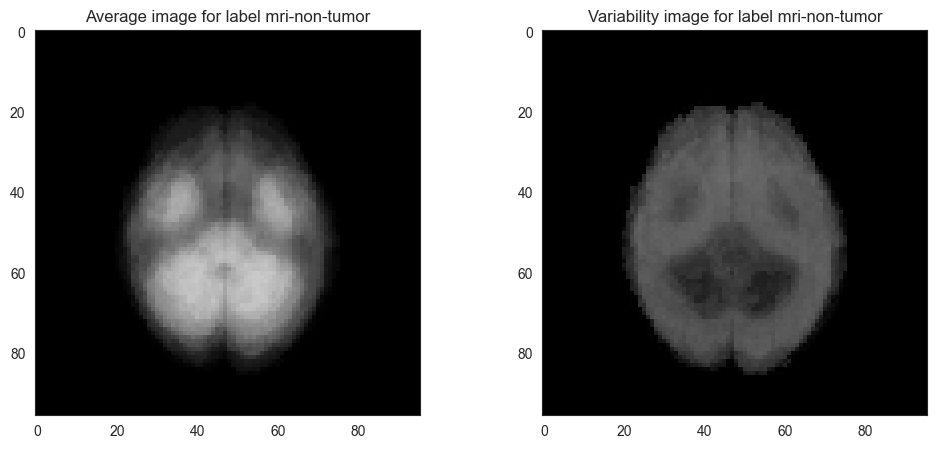

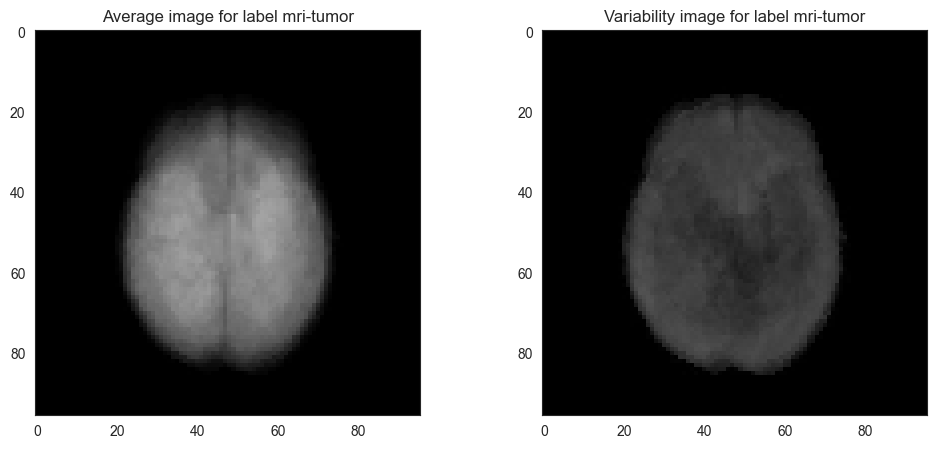

In [14]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12, 5), save_image=True)


## Difference between average healthy brain MRI and the one with tumor

In [15]:
def subset_image_label(X, y, label_to_display):
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
    df = X[boolean_mask]
    return df


def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20, 5), save_image=False):
    """
    Checks if the labels exist in the set of unique labels
    Calculates the mean and difference for label1 and label2
    Plots a chart and saves it if save_image=True
    """
    sns.set_style("white")

    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(
            f"Either label {label} or label {label_2}, are not in {np.unique(y)} ")
        return

    images_label = subset_image_label(X, y, label_1)
    label1_avg = np.mean(images_label, axis=0)

    images_label = subset_image_label(X, y, label_2)
    label2_avg = np.mean(images_label, axis=0)

    difference_mean = label1_avg - label2_avg
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'Average {label_1}')
    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'Average {label_2}')
    axes[2].imshow(difference_mean, cmap='gray')
    axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')
    if save_image:
        plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


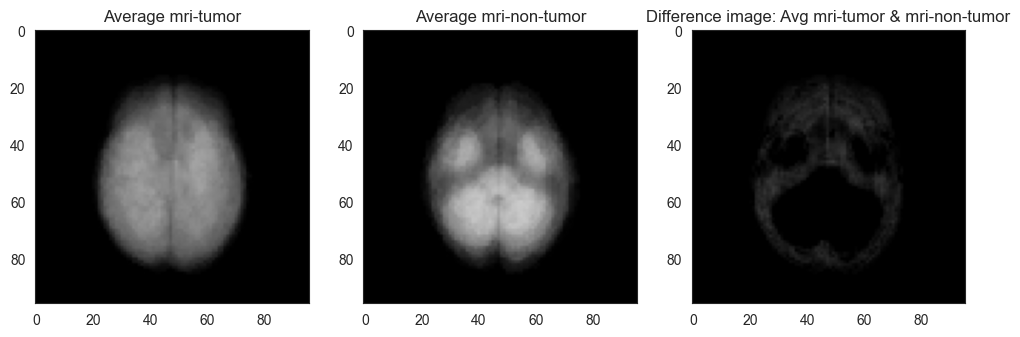

In [16]:
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='mri-tumor', label_2='mri-non-tumor',
                                        figsize=(12, 10),
                                        save_image=True
                                        )

---

## Image Montage

In [17]:
import itertools
import random
sns.set_style("white")


def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15, 10)):
    """
    if the label exists in the directory
    check if your montage space is greater than the subset size
    create a list of axes indices based on nrows and ncols
    create a Figure and display images
    in this loop, load and plot the given image
    """

    labels = os.listdir(dir_path)

    if label_to_display in labels:

        images_list = os.listdir(os.path.join(dir_path, label_to_display))
        if nrows * ncols < len(images_list):
            img_idx = random.sample(images_list, nrows * ncols)
        else:
            print(
                f"Decrease nrows or ncols to create your montage. \n"
                f"There are {len(images_list)} in your subset. "
                f"You requested a montage with {nrows * ncols} spaces")
            return

        list_rows = range(0, nrows)
        list_cols = range(0, ncols)
        plot_idx = list(itertools.product(list_rows, list_cols))

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        for x in range(0, nrows*ncols):
            img = imread(os.path.join(dir_path, label_to_display, img_idx[x]))
            img_shape = img.shape
            axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
            axes[plot_idx[x][0], plot_idx[x][1]].set_title(
                f"Width {img_shape[1]}px x Height {img_shape[0]}px")
            axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
            axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
        plt.tight_layout()
        plt.show()

    else:
        print("The label you selected doesn't exist.")
        print(f"The existing options are: {labels}")


Run Montage in all labels

mri-tumor


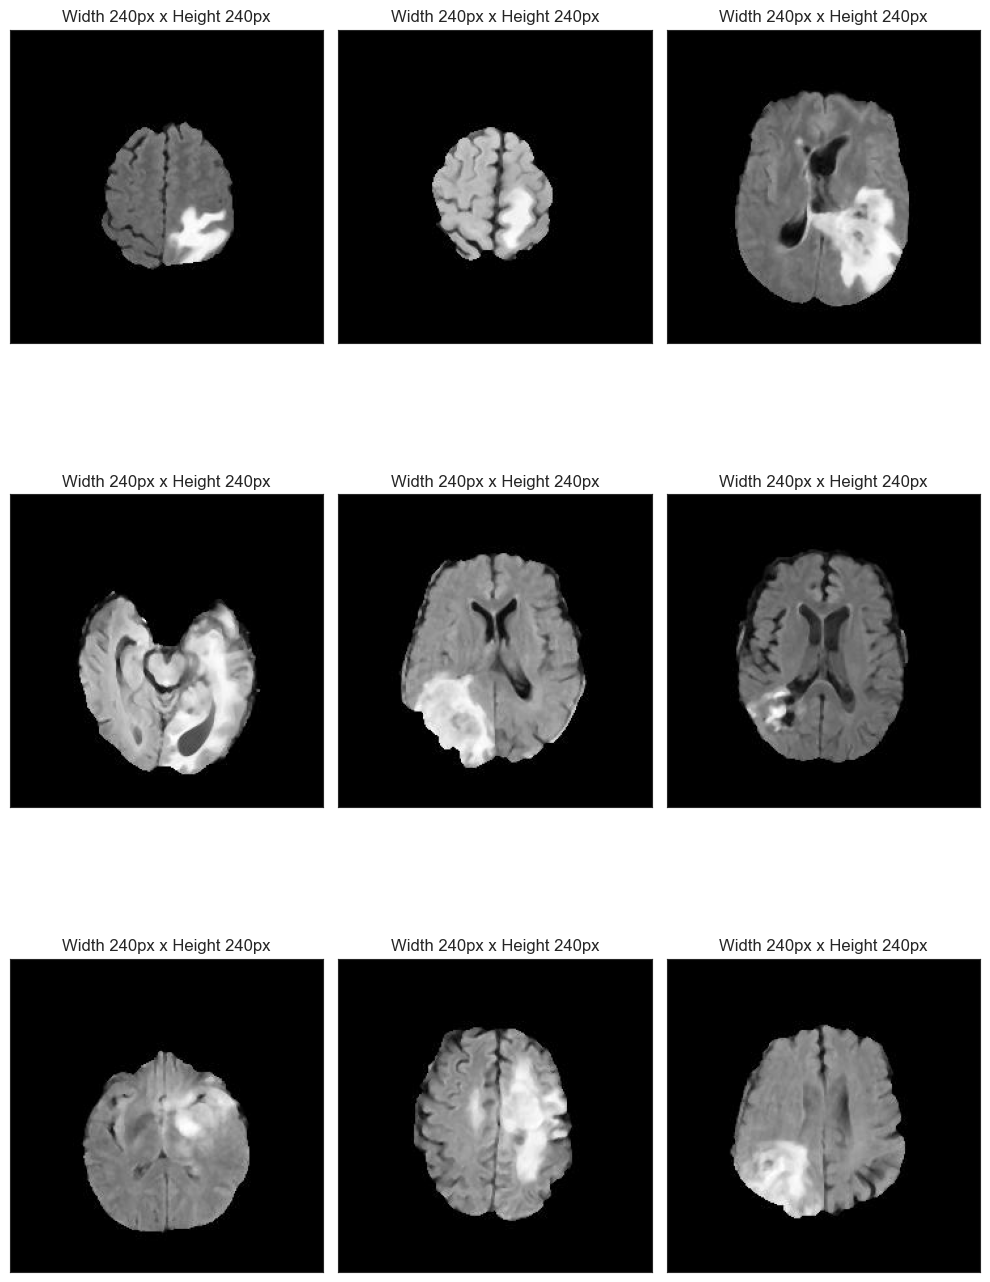



mri-non-tumor


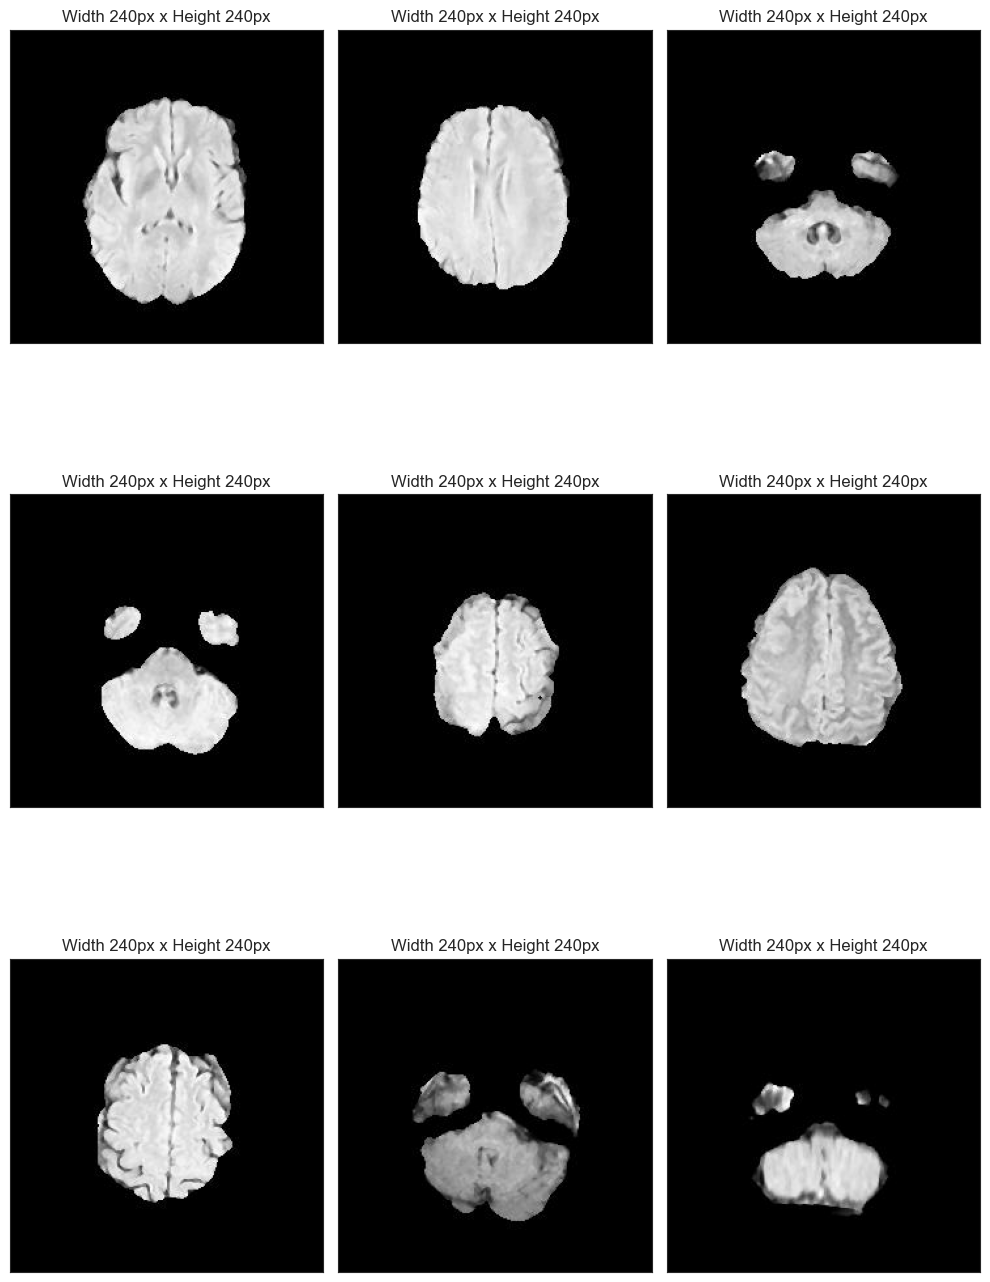

In [18]:
for label in labels:
    print(label)
    image_montage(dir_path=train_path,
                  label_to_display=label,
                  nrows=3, ncols=3,
                  figsize=(10, 15)
                  )
    print("\n")

---

# Conclusion and Next Steps

From the analysis, it can be concluded:
1. Non tumor brain MRIs tend to brighter and the shape of the brain isn't quite monolithic.
2. Non tumor brain MRIs had more visible cortical gyri.
3. Tumor brain MRIs are darker (gray) in color and are of a fuller round shape.
4. Cortical gyri aren't as visible and the image pattern is consistent through the whole image (or through the infected area). 


Follows Modelling and Evaluation Jupyter Notebook


---

### Note
It would be useful to make a code that will reshape the unseen input MRI brain scan into an average shape befor evaluation of the model for the dashboard